In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [30]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [32]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///C:\\Users\\maria\\Downloads\\Starter_Code (12)\\Starter_Code\\Resources\\hawaii.sqlite")


In [33]:
# Declare a Base using `automap_base()`

Base = automap_base()

# Use the Base class to reflect the database tables

Base.prepare(engine, reflect=True)


C:\Users\maria\AppData\Local\Temp\ipykernel_5680\2871949975.py:7: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [34]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [35]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`

# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes['measurement']

# Assign the station class to a variable called `Station`
Station = Base.classes['station']


In [36]:
# Create a session
session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [37]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).one()[0]

print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


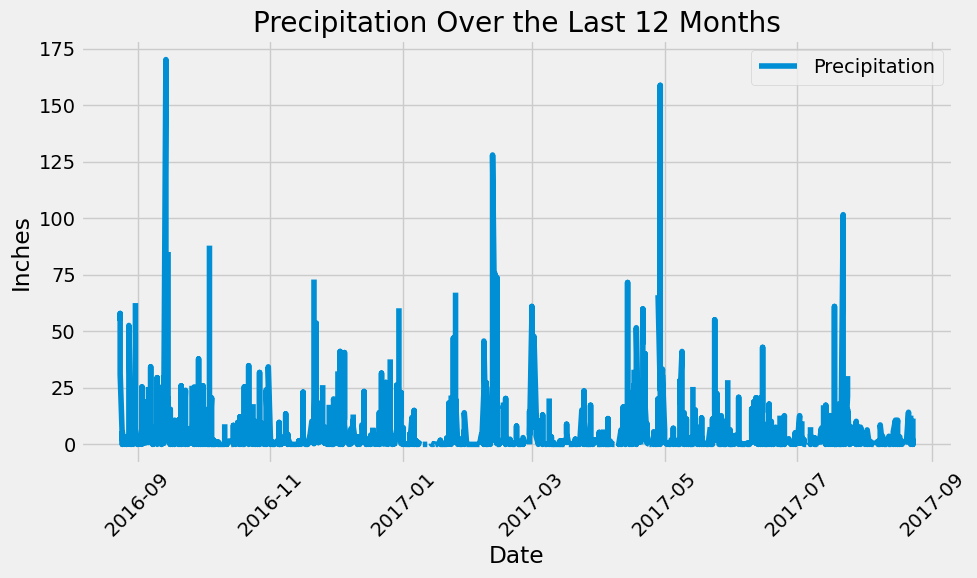

In [38]:

# Step 1: Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()
if most_recent_date is None:
    raise ValueError("No data available in the Measurement table.")
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Step 2: Calculate the date one year from the last date in data set
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Step 3: Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date >= one_year_ago).\
                  all()

# Step 4: Save the query results as a Pandas DataFrame and set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])

# Step 5: Sort the DataFrame by date
df.sort_values('Date', inplace=True)

# Step 6: Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Precipitation'], label='Precipitation')
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.xticks(rotation=45)  # Adjust rotation for better legibility
plt.tight_layout()
plt.show()

In [39]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = df['Precipitation'].describe()

# Print the summary statistics
print(precipitation_stats)

count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [40]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print("Total number of stations:", total_stations)

Total number of stations: 9


In [41]:
# Query to find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                              group_by(Measurement.station).\
                              order_by(func.count(Measurement.station).desc()).\
                              all()

# Display the list of stations and their counts in descending order
for station, count in active_stations:
    print(f"Station {station} has {count} records.")

Station USC00519281 has 2772 records.
Station USC00519397 has 2724 records.
Station USC00513117 has 2709 records.
Station USC00519523 has 2669 records.
Station USC00516128 has 2612 records.
Station USC00514830 has 2202 records.
Station USC00511918 has 1979 records.
Station USC00517948 has 1372 records.
Station USC00518838 has 511 records.


In [42]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


# Assuming `active_stations` holds the result from the previous query
most_active_station = active_stations[0][0]  # Get the ID of the most active station

# Query to find the lowest, highest, and average temperature of the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).all()

# Unpack the result
min_temp, max_temp, avg_temp = temperature_stats[0]

print(f"Lowest Temperature at Station {most_active_station}: {min_temp}°F")
print(f"Highest Temperature at Station {most_active_station}: {max_temp}°F")
print(f"Average Temperature at Station {most_active_station}: {avg_temp:.2f}°F")


Lowest Temperature at Station USC00519281: 12.2°F
Highest Temperature at Station USC00519281: 29.4°F
Average Temperature at Station USC00519281: 22.04°F


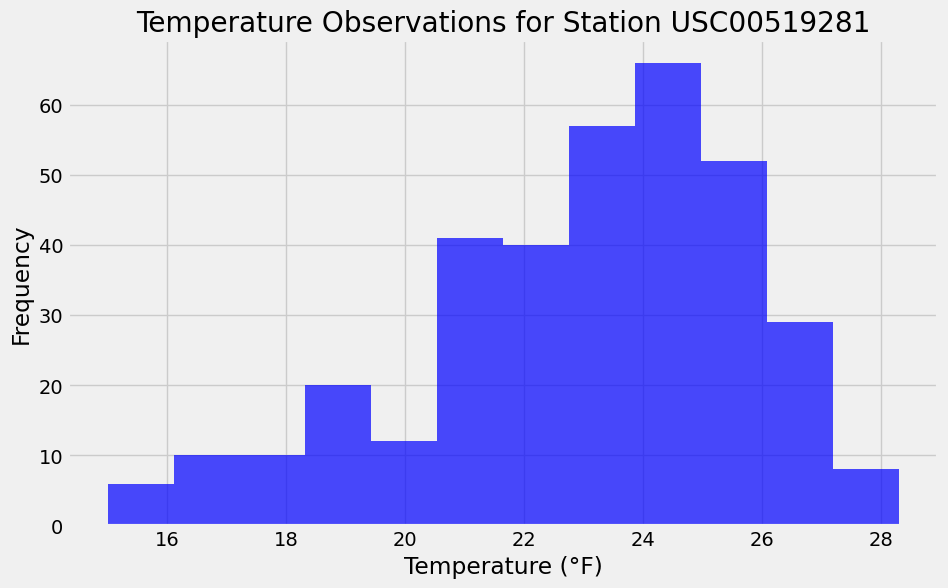

In [43]:
# Assuming you already have the most recent date and the most active station ID
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Using the most active station id, query the last 12 months of temperature observation data
temperature_data = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station).\
                    filter(Measurement.date >= one_year_ago).\
                    all()

# Extract temperature observations from the query results
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, color='blue', alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [44]:
# Close Session
session.close()
